# Build Datasets: ML & CV Orchestrator

Run from the **project root**. It uses your `scripts/` modules to generate:
- ML features and labels parquet datasets
- Optional CV image renders for visual QA

Edit parameters in the next cell and execute top-to-bottom.


In [1]:
# Рабочий каталог = корень проекта
import os, sys, pathlib
ROOT = pathlib.Path(r"C:\Users\Admin\Desktop\Code\Trade-bot")  # подправь путь при необходимости
os.chdir(ROOT)
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Авто-перезагрузка модулей при правках
%load_ext autoreload
%autoreload 2

import platform, pandas as pd
print("CWD:", pathlib.Path().resolve())
print("Python:", platform.python_version())


CWD: C:\Users\Admin\Desktop\Code\Trade-bot
Python: 3.11.0


In [49]:
TICKER     = "GMKN" # ["SBER", "GAZP", "LKOH", "ROSN", "GMKN"]
TF         = "1m"                  # "1m" / "5m" / "1h" / "1d"
START      = "2025-06-02"
END        = "2025-10-10"
FIGI       = "BBG00475KKY8"        # FIGI SBER (пример)
YF_SYMBOL  = "GMKN.ME"             # запасной символ для yfinance

RAW_GLOB   = f"data/raw/*/{TICKER}/{TF}/year=*/month=*/part.parquet"
FEAT_PATH  = f"data/features/ml/{TICKER}/{TF}/features.parquet"
FEAT_LBL   = f"data/features/ml/{TICKER}/{TF}/features_labeled.parquet"


In [50]:
from scripts import fetch_data as F
import pandas as pd

# В модуле могло не быть fetch_intraday — добавим тонкую обёртку тут
def fetch_intraday(ticker: str, tf: str, start, end, figi: str|None=None, yf_symbol: str|None=None):
    if hasattr(F, "fetch_intraday"):
        return F.fetch_intraday(ticker, tf, start, end, figi, yf_symbol)
    # Иначе используем функции из модуля (Tinkoff -> MOEX -> yfinance)
    from datetime import datetime
    def _dt(x): 
        return x if isinstance(x, datetime) else datetime.fromisoformat(str(x))
    START, END = _dt(start), _dt(end)
    try:
        if figi:
            dft = F.fetch_tinkoff_chunked(figi, tf, START, END)
            if not dft.empty:
                return dft.sort_values("time").drop_duplicates("time"), "tinkoff"
    except Exception: 
        pass
    try:
        dfm = F.fetch_moex_history(ticker, tf, str(START.date()), str(END.date()))
        if not dfm.empty:
            return dfm.sort_values("time").drop_duplicates("time"), "moex"
    except Exception:
        pass
    sym = yf_symbol or f"{ticker}.ME"
    dfy = F.fetch_yf(sym, tf, str(START.date()))
    if not dfy.empty:
        return dfy.sort_values("time").drop_duplicates("time"), "yfinance"
    return pd.DataFrame(), None

df_raw, src = fetch_intraday(TICKER, TF, START, END, figi=FIGI, yf_symbol=YF_SYMBOL)
print("source:", src, "rows:", len(df_raw), df_raw["time"].min() if len(df_raw) else None, "→", df_raw["time"].max() if len(df_raw) else None)
df_raw.head()


source: tinkoff rows: 123770 2025-06-02 03:59:00+00:00 → 2025-10-09 20:49:00+00:00


,time,open,high,low,close,volume
0,2025-06-02 03:59:00+00:00,1057.0,1057.0,1057.0,1057.0,7342
1,2025-06-02 04:00:00+00:00,1057.2,1067.0,1056.0,1061.8,38146
2,2025-06-02 04:01:00+00:00,1061.6,1065.6,1059.8,1064.0,13667
3,2025-06-02 04:02:00+00:00,1063.8,1067.6,1063.8,1065.6,14318
4,2025-06-02 04:03:00+00:00,1065.8,1066.6,1064.2,1065.0,5304


In [51]:
if not df_raw.empty:
    F.save_partitioned(df_raw, source=src or "tinkoff", ticker=TICKER, tf=TF)


In [52]:
from scripts.make_intraday_features import build_features
import os
os.makedirs(os.path.dirname(FEAT_PATH), exist_ok=True)

fe = build_features(RAW_GLOB)
fe.to_parquet(FEAT_PATH, index=False)
len(fe), FEAT_PATH


(123770, 'data/features/ml/GMKN/1m/features.parquet')

In [53]:
from scripts.make_labels import next_k_return, triple_barrier
df = pd.read_parquet(FEAT_PATH).sort_values("time")

df = next_k_return(df, k=5)                 # добавит ret_fwd_5
df = triple_barrier(df, k=20, up=0.004, dn=0.004)  # добавит y_tb_20

df.to_parquet(FEAT_LBL, index=False)
len(df), df.columns.tolist()[-6:], FEAT_LBL


(123770,
 ['date', 'bar_id', 'is_open_30', 'is_close_30', 'ret_fwd_5', 'y_tb_20'],
 'data/features/ml/GMKN/1m/features_labeled.parquet')

In [54]:
from scripts.render_cv_images import render_with_manifest
MANIFEST = f"data/cv/images/{TICKER}/{TF}/win64_step16/manifest_with_vol.csv"

rows = render_with_manifest(
    in_parquet = FEAT_LBL,
    ticker     = TICKER,
    tf         = TF,
    size       = 64,
    step       = 16,
    horizon    = 5,
    show_axes  = False,          # True для дебага с осями
    show_volume= True,           # рисуем колонны объёма
    vol_mode   = "raw",          # 'raw' | 'zscore' | 'rel'
    fixed_ylim = "window",       # автоскейл по окну для цен
    manifest_csv = MANIFEST
)
len(rows), MANIFEST


C:\Users\Admin\Desktop\Code\Quant\.venv\Lib\site-packages\mplfinance\plotting.py:596: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
C:\Users\Admin\Desktop\Code\Quant\.venv\Lib\site-packages\mplfinance\plotting.py:596: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
C:\Users\Admin\Desktop\Code\Quant\.venv\Lib\site-packages\mplfinance\plotting.py:596: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axA1.set_ylim(config['ylim'][0], config['ylim'][1])
C:\Users\Admin\Desktop\Code\Quant\.venv\Lib\site-packages\mplfinance\plotting.py:596: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axA1.set_ylim(config['ylim']

(7732, 'data/cv/images/GMKN/1m/win64_step16/manifest_with_vol.csv')

In [55]:
from scripts.qc_report import qc_summary
qc = qc_summary(RAW_GLOB)
qc


,rows,zero_price,bad_hl,zero_vol,max_gap
0,123770,0,0,0,0 days 07:11:00


In [56]:
import glob
files = glob.glob(f"data/features/ml/{TICKER}/{TF}/*.parquet")
mart = (pd.concat((pd.read_parquet(p) for p in files), ignore_index=True)
          .drop_duplicates("time").sort_values("time"))
os.makedirs("warehouse", exist_ok=True)
MART_FILE = f"warehouse/{TICKER.lower()}_{TF}.parquet"
mart.to_parquet(MART_FILE, index=False)
len(mart), MART_FILE


(123770, 'warehouse/gmkn_1m.parquet')

In [57]:
pd.read_parquet(FEAT_LBL).tail()


,time,open,high,low,close,volume,ret_1,ret_5,rng_1,vol_20,vwap_20,dist_vwap,date,bar_id,is_open_30,is_close_30,ret_fwd_5,y_tb_20
123765,2025-10-09 20:45:00+00:00,1056.2,1056.4,1056.2,1056.4,954,-0.000568,-0.000189,0.000189,0.000405,1056.885552,-0.000460,2025-10-09,987,0,1,0.000568,0
123766,2025-10-09 20:46:00+00:00,1056.6,1056.6,1056.4,1056.6,29,0.000189,0.000189,0.000189,0.000397,1056.881324,-0.000266,2025-10-09,988,0,1,0.004909,0
123767,2025-10-09 20:47:00+00:00,1056.6,1056.8,1056.6,1056.8,810,0.000189,-0.000189,0.000189,0.000397,1056.853796,-0.000051,2025-10-09,989,0,1,0.006790,0
123768,2025-10-09 20:48:00+00:00,1056.8,1056.8,1055.8,1056.0,548,-0.000757,-0.000757,0.000946,0.000430,1056.801951,-0.000759,2025-10-09,990,0,1,0.009050,0
123769,2025-10-09 20:49:00+00:00,1056.4,1057.8,1056.0,1056.6,2265,0.000568,-0.000379,0.001705,0.000430,1056.752542,-0.000144,2025-10-09,991,0,1,0.007919,0


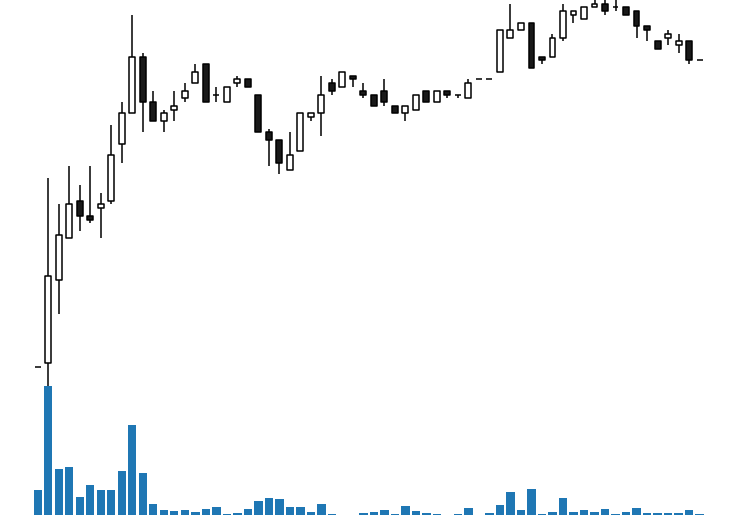

In [58]:
# показать одну сгенерированную картинку
from IPython.display import Image, display
import glob
imgs = glob.glob(f"data/cv/images/{TICKER}/{TF}/win64_step16/*/img_*.png")
display(Image(filename=imgs[0])) if imgs else print("Нет изображений.")


Playing with stochastic

In [59]:
# Monte-Carlo valuation: FV/PV, mispricing metrics
import numpy as np, pandas as pd
from dataclasses import dataclass

# --- вход: путь к файлу с ценами (достаточно колонок time, close) ---
PATH = f"warehouse/{TICKER.lower()}_1m.parquet"  # можно заменить на daily файл с колонками time, close
# TICKER = "SBER"

# --- параметры моделирования ---
HORIZON_DAYS = 20             # горизонт прогноза в торговых днях
N_SIMS       = 20000          # число симуляций
MODEL        = "gbm"          # "gbm" или "bootstrap" (эмпирическое бутстрапирование дневных ретёрнов)
DT           = 1/252          # шаг (в годах) для дневной сетки
R_ANNUAL     = 0.12           # годовая ставка дисконтирования (напр., рубл. безрисковая/требуемая доходность)
USE_LOG      = True           # PV/FV считаем из лог-нормальной цены
SEED         = 42

# --- подготовка дневных ретёрнов из произвольной частоты ---
df = pd.read_parquet(PATH).sort_values("time").copy()
df["time"] = pd.to_datetime(df["time"])
# если это минутки — агрегируем в дневные "close" по последнему бару
daily = (df.set_index("time")[["close"]]
           .resample("1D").last()
           .dropna().rename(columns={"close":"close"}))

# фильтр по торговым дням (исключим дни без движения, если были)
daily = daily.replace([np.inf, -np.inf], np.nan).dropna()
px = daily["close"].astype(float)
r  = np.log(px).diff().dropna() if USE_LOG else px.pct_change().dropna()

# --- калибровка параметров GBM ---
mu_hat  = r.mean() * 252      # годовой дрейф по историческим данным
sig_hat = r.std(ddof=1) * np.sqrt(252)  # годовая волатильность

@dataclass
class MCResult:
    fv_stats: pd.DataFrame
    pv_stats: pd.DataFrame
    details: dict

np.random.seed(SEED)
S0 = float(px.iloc[-1])

def mc_simulate(S0, horizon_days, n_sims, model="gbm"):
    steps = horizon_days
    if model == "gbm":
        # дневная дискретизация GBM
        mu_d  = mu_hat / 252.0
        sig_d = sig_hat / np.sqrt(252.0)
        # S_T = S0 * exp(sum((mu - 0.5*sigma^2)*dt + sigma*sqrt(dt)*Z))
        z = np.random.normal(size=(steps, n_sims))
        increments = (mu_d - 0.5*sig_d**2) + sig_d * z  # dt=1 день
        log_ST = np.log(S0) + increments.sum(axis=0)
        ST = np.exp(log_ST)
    elif model == "bootstrap":
        # эмпирическое бутстрапирование дневных ретов
        boot_r = np.random.choice(r.values, size=(steps, n_sims), replace=True)
        if USE_LOG:
            ST = S0 * np.exp(boot_r.sum(axis=0))
        else:
            ST = S0 * np.prod(1 + boot_r, axis=0)
    else:
        raise ValueError("Unknown model")
    return ST

# --- считaем распределения FV и PV ---
ST = mc_simulate(S0, HORIZON_DAYS, N_SIMS, MODEL)
# FV = ST (будущая стоимость на горизонте)
FV = ST
# PV = ожидаемая будущая стоимость, дисконтированная в "сегодня"
disc = np.exp(-R_ANNUAL * (HORIZON_DAYS/252.0))
PV  = FV * disc

def summarize(vec):
    return pd.Series({
        "mean": np.mean(vec),
        "median": np.median(vec),
        "p05": np.percentile(vec, 5),
        "p25": np.percentile(vec, 25),
        "p75": np.percentile(vec, 75),
        "p95": np.percentile(vec, 95),
        "std": np.std(vec, ddof=1)
    })

fv_stats = summarize(FV)
pv_stats = summarize(PV)

# --- метрики "переоценен/недооценен" ---
cur = S0
# вероятность, что дисконтированная стоимость > текущей цены
p_pv_gt_spot = float((PV > cur).mean())
# ожидаемая доходность к горизонту (реальная, не дисконт.)
exp_ret = float((FV/cur - 1.0).mean())
# миспрайсинг как отношение справедливой PV к споту
pv_fair = pv_stats["mean"]
mispricing_ratio = float(pv_fair / cur)   # >1 недооценен, <1 переоценен
# z-score текущей цены относительно PV-распределения
pv_std = pv_stats["std"]
pv_z = float((cur - pv_fair) / pv_std) if pv_std > 0 else np.nan
# вероятность убытка на горизонте
p_loss = float((FV < cur).mean())
# ожидаемый shortfall при 5% (ES)
q05 = np.percentile(FV, 5)
es05 = float(FV[FV <= q05].mean()) if (FV <= q05).any() else np.nan

report = pd.DataFrame({
    "ticker": [TICKER],
    "model": [MODEL],
    "S0": [cur],
    "H_days": [HORIZON_DAYS],
    "r_annual": [R_ANNUAL],
    "mu_ann_hist": [mu_hat],
    "sigma_ann_hist": [sig_hat],
    "PV_mean": [pv_fair],
    "PV/Spot": [mispricing_ratio],
    "PV_z": [pv_z],
    "P(PV>Spot)": [p_pv_gt_spot],
    "E[Ret]": [exp_ret],
    "P(Loss)": [p_loss],
    "ES_5pct": [es05],
    "FV_p05": [np.percentile(FV,5)],
    "FV_p50": [np.percentile(FV,50)],
    "FV_p95": [np.percentile(FV,95)]
})

print("=== FV stats ==="); display(fv_stats.to_frame("value"))
print("=== PV stats ==="); display(pv_stats.to_frame("value"))
print("=== Valuation report ==="); display(report)


=== FV stats ===


,value
mean,1048.047055
median,1044.051753
p05,899.953255
p25,982.280949
p75,1108.522834
p95,1209.007998
std,94.087288


=== PV stats ===


,value
mean,1038.113034
median,1034.155602
p05,891.422957
p25,972.970300
p75,1098.015587
p95,1197.548293
std,93.195472


=== Valuation report ===


,ticker,model,S0,H_days,r_annual,mu_ann_hist,sigma_ann_hist,PV_mean,PV/Spot,PV_z,P(PV>Spot),E[Ret],P(Loss),ES_5pct,FV_p05,FV_p50,FV_p95
0,GMKN,gbm,1056.6,20,0.12,-0.102289,0.319687,1038.113034,0.982503,0.198368,0.40565,-0.008095,0.55155,867.680916,899.953255,1044.051753,1209.007998


In [36]:
# HAR-RV из минуток → дневная RV → OLS с константой → прогноз σ на следующий день

import numpy as np, pandas as pd, statsmodels.api as sm

# 1) загрузка минуток (должны быть time, close)
m = pd.read_parquet(FEAT_PATH).sort_values("time").copy()
m["time"] = pd.to_datetime(m["time"], utc=True)

# 2) минутные лог-ретёрны и дневная realized variance
m["ret"] = np.log(m["close"]).diff()
m["date"] = m["time"].dt.tz_convert(None).dt.date
rv_daily = (m.dropna(subset=["ret"])
              .groupby("date")["ret"]
              .apply(lambda x: np.sum(x.values**2))
              .rename("rv")
              .to_frame())

# 3) признаки HAR: d-1, weekly(5), monthly(22) — все лагируем на 1 день
d = rv_daily.copy()
d["rv_d1"] = d["rv"].shift(1)
d["rv_w"]  = d["rv"].rolling(5).mean().shift(1)
d["rv_m"]  = d["rv"].rolling(22).mean().shift(1)

# 4) обучающая выборка без NaN
D = d.dropna().copy()
assert len(D) >= 40, "Мало данных для HAR-RV"

# 5) дизайн-матрица c константой
X = sm.add_constant(D[["rv_d1","rv_w","rv_m"]])
y = D["rv"]

model = sm.OLS(y, X).fit()

# 6) предиктор на «завтра»: берём ПОСЛЕДНЮЮ строку признаков и подаём те же столбцы X.columns
x_last = d[["rv_d1","rv_w","rv_m"]].iloc[[-1]].copy()
if x_last.isna().any(axis=1).iloc[0]:
    # если не хватает истории для недельного/месячного окна — используем последнюю валидную строку
    x_last = D[["rv_d1","rv_w","rv_m"]].iloc[[-1]].copy()

x_last_const = pd.concat([pd.Series({"const":1.0}), x_last.squeeze()]).to_frame().T
x_last_const = x_last_const[X.columns]  # порядок и набор столбцов как у обучения

rv_pred = float(model.predict(x_last_const).iloc[0])
rv_pred = max(rv_pred, 0.0)             # неотрицательность
sigma_pred = float(np.sqrt(rv_pred))    # дневная σ

print(f"HAR-RV: rv_pred={rv_pred:.6f}, sigma_pred={sigma_pred:.6f}")


HAR-RV: rv_pred=0.000214, sigma_pred=0.014637


In [37]:
# pip install arch
import pandas as pd, numpy as np
from arch import arch_model
prices = pd.read_parquet(MART_FILE)[["time","close"]].sort_values("time")
r_d = np.log(prices["close"]).diff().dropna()*100  # в %
am = arch_model(r_d, vol="Garch", p=1, q=1, dist="normal").fit(disp="off")
fore = am.forecast(horizon=HORIZON_DAYS, reindex=False)
sigma_garch_day = float(np.sqrt(fore.variance.values[-1].mean())/100)  # вернём в долях


In [38]:
# вместо исторической sig_hat используем mix:
sig_hat = float(0.5*sigma_pred + 0.5*sigma_garch_day)


In [39]:
# pip install hmmlearn
import numpy as np, pandas as pd
from hmmlearn.hmm import GaussianHMM
r_d = np.log(daily["close"]).diff().dropna().values.reshape(-1,1)
hmm = GaussianHMM(n_components=2, covariance_type="full", n_iter=200, random_state=42).fit(r_d)
weights = hmm.predict_proba(r_d)[-1]  # постериоры последнего дня
mus = hmm.means_.flatten()
sigmas = np.sqrt(np.array([np.squeeze(c) for c in hmm.covars_]))
# в MC смешиваем два набора μ_d, σ_d по весам


Model is not converging.  Current: 860.2355892629803 is not greater than 860.3282625280441. Delta is -0.09267326506380869


In [40]:
# pip install hmmlearn scikit-learn
import numpy as np, pandas as pd
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

# r_d: дневные лог-ретёрны, 1D колонка
r_d = np.log(daily["close"]).diff().dropna().values.reshape(-1,1)
assert len(r_d) >= 250, "Нужно ≥ ~1 года дневных точек для устойчивости"

# стандартизация
sc = StandardScaler()
r_s = sc.fit_transform(r_d)

def fit_hmm_multi(X, n_components=2, n_restarts=5, seed0=42):
    best, best_score = None, -np.inf
    for s in range(n_restarts):
        mdl = GaussianHMM(
            n_components=n_components,
            covariance_type="diag",   # устойчивее, чем full для 1D
            n_iter=1000,
            tol=1e-4,
            min_covar=1e-6,
            random_state=seed0+s,
            verbose=False
        )
        mdl.fit(X)
        score = mdl.score(X)
        if score > best_score:
            best, best_score = mdl, score
    return best

hmm = fit_hmm_multi(r_s, n_components=2, n_restarts=8)

print("Converged:", hmm.monitor_.converged, "score:", hmm.score(r_s))

# постериоры последнего дня
weights = hmm.predict_proba(r_s)[-1]

# параметры в исходном масштабе
mus_s    = hmm.means_.flatten()              # в z-скейле
sigmas_s = np.sqrt(hmm.covars_.flatten())    # diag ковары в z-скейле

# обратная трансформация
mus    = (mus_s * sc.scale_) + sc.mean_
sigmas = sigmas_s * sc.scale_

print("Regime μ:", mus, "σ:", sigmas, "weights:", weights)


Converged: True score: -380.5049909284549
Regime μ: [ 0.00254688 -0.00128588] σ: [0.02251484 0.00813513] weights: [0.04359322 0.95640678]
